In [1]:
import os 
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import shutil

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from tqdm import tqdm

from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
rect_coords = [
    (675, 10, 1242, 85),
    (1755, 5, 1916, 72),
    (292, 95, 2, 5),
    (1630, 793, 1915, 1074),
    (597, 846, 1335, 1077),
    (1828, 126, 1918, 648),
    (83, 132, 1, 655),
]

In [3]:
class MaskTransform:
    def __init__(self, rect_coords):
        self.rect_coords = rect_coords

    def __call__(self, image):
        # all black mask
        mask = Image.new('RGB', image.size, (0, 0, 0))
        draw = ImageDraw.Draw(mask)

        for rect in self.rect_coords:
            x1, y1 = min(rect[0], rect[2]), min(rect[1], rect[3])
            x2, y2 = max(rect[0], rect[2]), max(rect[1], rect[3])
            # whiltens the selected areas
            draw.rectangle([x1, y1, x2, y2], fill=(255, 255, 255))

        # composite the image and mask
        masked_image = Image.composite(image, mask, mask.convert("L")) 
        return masked_image

class MatchDataset(Dataset):
    def __init__(self, labels_csv, images_dir, transform=None):
        self.data = pd.read_csv(labels_csv)
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.images_dir, row['image'])
        label = row['label']

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
transform = transforms.Compose([
    MaskTransform(rect_coords),      
    transforms.Resize((600, 600)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [5]:
def create_dataloader(split_name, base_dir, transform, batch_size=32, shuffle=True):
    labels_csv = os.path.join(base_dir, f"{split_name}_labels.csv")
    images_dir = os.path.join(base_dir, split_name)
    dataset = MatchDataset(labels_csv, images_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [6]:
base_dir_by_match = './data/split_by_match_dataset'
batch_size = 32

In [7]:
train_loader = create_dataloader("train", base_dir_by_match, transform, batch_size=batch_size)
val_loader = create_dataloader("val", base_dir_by_match, transform, batch_size=batch_size)
test_loader = create_dataloader("test", base_dir_by_match, transform, batch_size=batch_size)

In [8]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_ratio, stride, kernel_size, se_ratio=0.25):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        mid_channels = in_channels * expansion_ratio

        # 1. Expansion Phase. no need to add bias since we have batch normalization
        self.expansion = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels, momentum=0.99)
        self.act1 = nn.SiLU()

        # 2. Depthwise Convolution
        self.depthwise = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels, momentum=0.99)
        self.act2 = nn.SiLU()

        # SE module -> learn channel-wise interactions suc that the network can dynamically learn which channels are important
        se_channels = max(1, int(in_channels * se_ratio))
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Global Average Pooling: HxWxC -> 1x1 ==> it compresses the spatial information to a single value, showing global information
            nn.Conv2d(mid_channels, se_channels, kernel_size=1), # reduce the number of channels
            nn.SiLU(), # apply non-linearity
            nn.Conv2d(se_channels, mid_channels, kernel_size=1), # restore the number of channels
            nn.Sigmoid() # apply sigmoid to get the weights
        )

        # 3. Projection Phase
        self.projection = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels, momentum=0.99)

        # Skip connection -> can only apply when the input and output channels are the same
        self.apply_residual = (in_channels == out_channels) and (stride == 1)

    def forward(self, x):
        residual = x
        x = self.expansion(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.depthwise(x)
        x = self.bn2(x)
        x = self.act2(x)

        # apply SE module
        weights = self.se(x)
        x = x * weights

        x = self.projection(x)
        x = self.bn3(x)

        if self.apply_residual:
            x = x + residual
        
        return x

In [9]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNet, self).__init__()
        base_channels = 32

        # Stage 1: Conv3x3
        self.stage_1 = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels, momentum=0.99),
            nn.SiLU()
        )

        # Stages 2 ~ 8
        # in_channels, out_channels, num_blocks, stride, kernel_size, expansion_ratio
        stages = [
            [32, 16, 1, 1, 3, 1], # stage 2: 112x112 -> 112x112, 32 -> 16, num layers: 1, k3x3
            [16, 24, 2, 2, 3, 6], # stage 3: 112x112 -> 56x56, 16->24, num layers: 2, k3x3
            [24, 40, 2, 2, 5, 6], # stage 4: 56x56 -> 28x28, 24->40, num layers: 2, k5x5
            [40, 80, 3, 2, 3, 6], # stage 5: 28x28 -> 14x14, 40->80, num layers: 3, k3x3
            [80, 112, 3, 1, 5, 6], # stage 6: 14x14 -> 14x14, 80->112, num layers: 3, k5x5
            [112, 192, 4, 2, 5, 6], # stage 7: 14x14 -> 7x7, 112->192, num layers: 4, k5x5
            [192, 320, 1, 1, 3, 6] # stage 8: 7x7 -> 7x7, 192->320, num layers: 1, k3x3
        ]

        # MBCovBlocks
        layers = []
        in_channels_last = base_channels
        for in_channels, out_channels, num_blocks, stride, kernel_size, expansion_ratio in stages:
            for i in range(num_blocks):
                layers.append(MBConvBlock(
                    in_channels_last, 
                    out_channels, 
                    expansion_ratio, 
                    stride if i == 0 else 1, # only apply kernel to the first block 
                    kernel_size))
                in_channels_last = out_channels
        
        self.mbconv_stages = nn.Sequential(*layers)
        
        # Stage 9: Conv1x1
        self.stage_9 = nn.Sequential(
            nn.Conv2d(in_channels_last, 1280, kernel_size=1, bias=False), # 7 x 7 x 320 -> 7 x 7 x 1280
            nn.BatchNorm2d(1280, momentum=0.99),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1) # 7 x 7 x 1280 -> 1 x 1 x 1280
        )

        # fc 
        self.classifier = nn.Sequential(
            nn.Dropout(0.2), # based on the paper, the droupout is 0.2 for EfficientNet-B0
            nn.Linear(1280, num_classes)
        )
    
    # forward
    def forward(self, x):
        x = self.stage_1(x)
        # print(f"x: {x.shape}")
        x = self.mbconv_stages(x)
        # print(f"x: {x.shape}")
        x = self.stage_9(x)
        # print(f"x: {x.shape}")
        # need to flatten the tensor
        x = x.flatten(start_dim=1)  # 1x1x1280 -> 1280

        x = self.classifier(x)
        return x

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./weights/best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            print(f"Validation loss decreased ({self.best_loss:.4f} -> {val_loss:.4f}). Saving model...")
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_checkpoint(self, val_loss, model):        
        torch.save(model.state_dict(), self.path)

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, weight_name, num_epochs=100, patience=10):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'weights/best_{weight_name}.pth')

    # save
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Train
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(30*"-")

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_acc = correct_train / total_train * 100
        train_loss /= len(train_loader)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.2f}%")
    

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
            
        val_acc = correct_val / total_val * 100
        val_loss /= len(val_loader)

        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # update learning rate -> every 24 epoch
        if (epoch+1) % 5 == 0:
            scheduler.step()
            print(f"Learning rate updated")

    model.load_state_dict(torch.load(f'weights/best_{weight_name}.pth'))
    print("Training completed and the best model is loaded.")
    return model, history


In [12]:
# Test 
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    test_accuracy = 100 * correct_test / total_test
    test_loss = test_loss / len(test_loader)

    print(f"Test loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%")
    return test_loss, test_accuracy

In [13]:
def plot_history(history, save_path=None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # loss graph
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # accuracy graph
    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('Accuracy Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_combined.png")
    plt.show()

    # save individual plots
    # trian loss
    plt.figure(figsize=(7, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Train Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_train_loss.png")
    plt.show()

    # validation loss
    plt.figure(figsize=(7, 5))
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_val_loss.png")
    plt.show()

    # train accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history['train_acc'], label='Train Accuracy', color='green')
    plt.title('Train Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_train_acc.png")
    plt.show()

    # validation accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_val_acc.png")
    plt.show()

In [14]:
split_by_match_model = EfficientNet(num_classes=2)
split_by_match_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(split_by_match_model.parameters(), lr=0.001)

# decay the learning rate by a factor of 0.9 for every 24 epoch
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

In [15]:
split_by_match_model, split_by_match_history = train(
    model=split_by_match_model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    device=device, 
    weight_name="split_by_match_model", 
    num_epochs=100, 
    patience=3)

Epoch 1/100
------------------------------


Training: 100%|██████████| 106/106 [03:08<00:00,  1.78s/it]


Training loss: 0.2418, accuracy: 88.51%


Validation: 100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Validation loss: 1.7198, accuracy: 61.88%
Validation loss decreased (inf -> 1.7198). Saving model...
Epoch 2/100
------------------------------


Training: 100%|██████████| 106/106 [02:40<00:00,  1.52s/it]


Training loss: 0.0447, accuracy: 98.35%


Validation: 100%|██████████| 37/37 [00:46<00:00,  1.26s/it]


Validation loss: 2.0743, accuracy: 59.03%
EarlyStopping counter: 1 out of 3
Epoch 3/100
------------------------------


Training: 100%|██████████| 106/106 [02:40<00:00,  1.51s/it]


Training loss: 0.0286, accuracy: 98.97%


Validation: 100%|██████████| 37/37 [00:48<00:00,  1.30s/it]


Validation loss: 3.1084, accuracy: 59.72%
EarlyStopping counter: 2 out of 3
Epoch 4/100
------------------------------


Training: 100%|██████████| 106/106 [02:37<00:00,  1.48s/it]


Training loss: 0.0405, accuracy: 98.58%


Validation: 100%|██████████| 37/37 [00:45<00:00,  1.24s/it]

Validation loss: 2.4827, accuracy: 61.54%
EarlyStopping counter: 3 out of 3
Early stopping
Training completed and the best model is loaded.



/tmp/ipykernel_676043/486406362.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights/best_{weight_name}.pth'))


In [16]:
test_split_by_match_loss, test_split_by_match_acc = test(split_by_match_model, test_loader, criterion, device)

Testing: 100%|██████████| 38/38 [00:48<00:00,  1.28s/it]

Test loss: 1.4075, accuracy: 67.00%


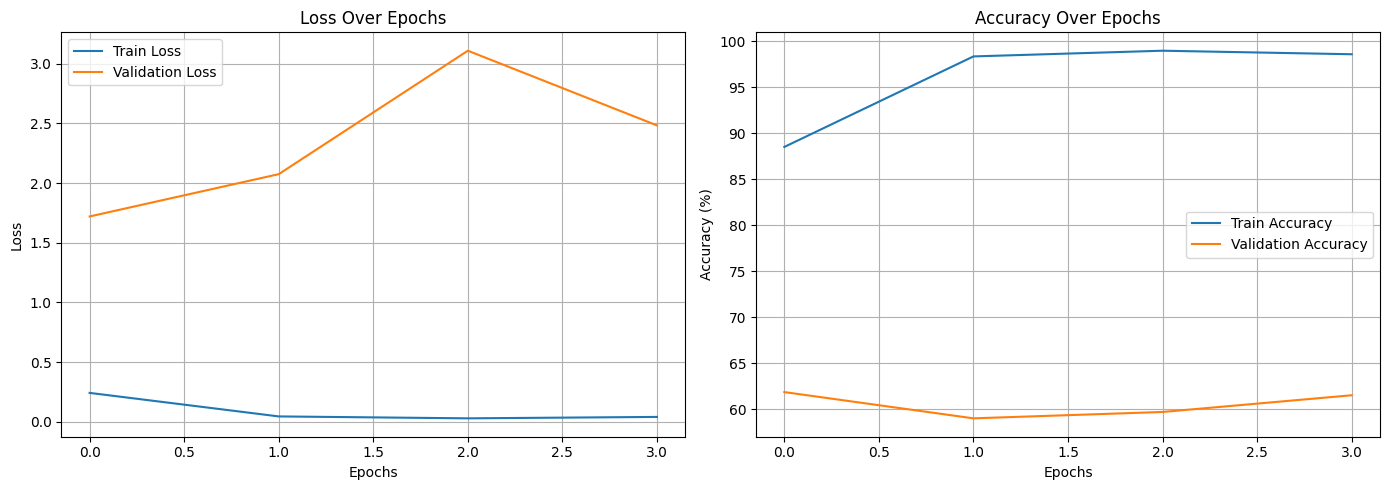

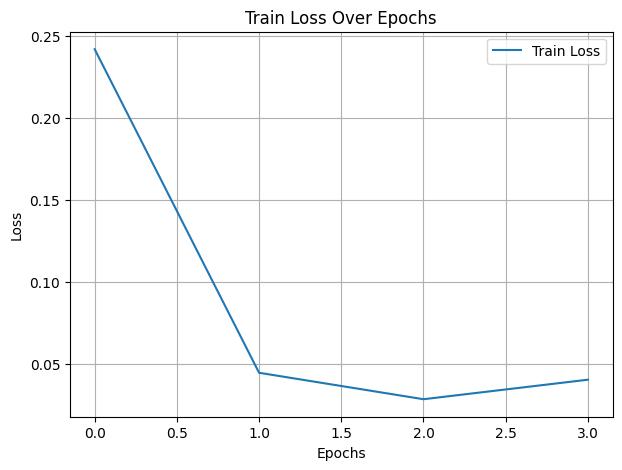

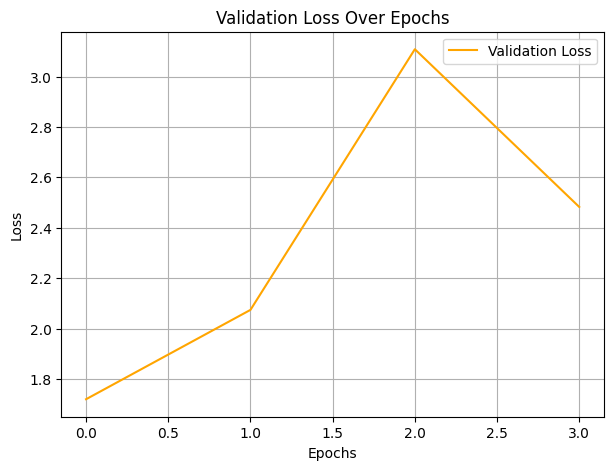

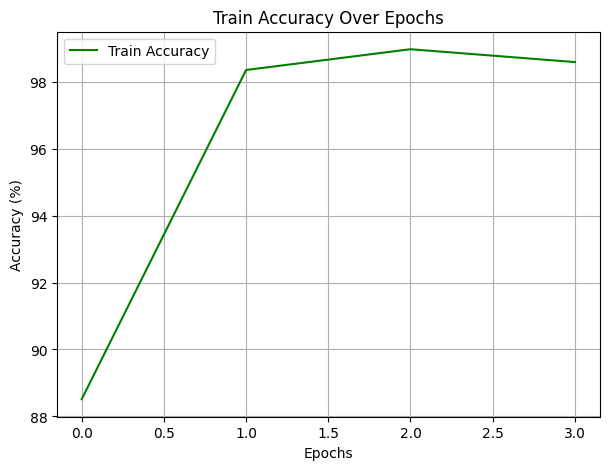

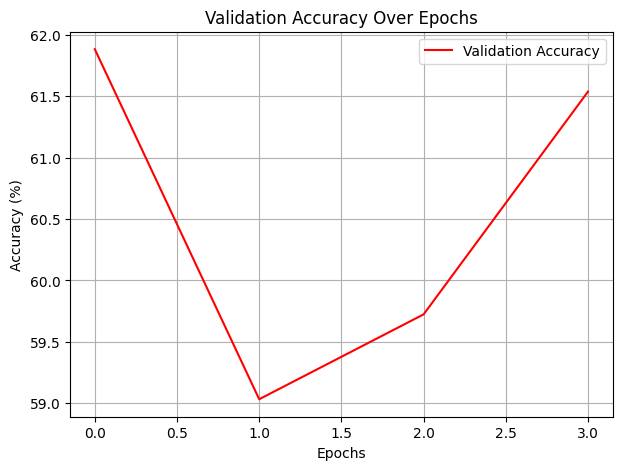

In [17]:
plot_history(split_by_match_history, save_path="./graphs/split_by_match_results")

In [18]:
def analyse_test_misclassification(model, test_loader, device, output_dir="./"):
    model.eval()
    misclassifications = []

    # predict and record misclassifications
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Analysing Test Misclassification")):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if predicted[i] != labels[i]:
                    dataset_idx = batch_idx * test_loader.batch_size + i
                    image_path = test_loader.dataset.data.iloc[dataset_idx]['image']
                    match_id = test_loader.dataset.data.iloc[dataset_idx]['match_id']

                    misclassifications.append({
                        'image': image_path,
                        'match_id': match_id,
                        'true_label': labels[i].item(),
                        'pred_label': predicted[i].item()
                    })

    # stage-wise analysis: early, mid, late
    stage_counts = {'early': 0, 'mid': 0, 'late': 0}
    stage_details = defaultdict(list)

    for misclass in misclassifications:
        image_path = misclass['image']
        
        try:
            # extract match id
            match_id = int(image_path.split('_')[1])  
            frame_idx = int(image_path.split('_')[-1].split('.')[0])  # Frame Index 추출
        except ValueError:
            print(f"Error parsing file name: {image_path}")
            continue

        # match_id에 해당하는 모든 프레임 파일 가져오기
        frames_dir = "./data/augmented_split_by_match_dataset/test"
        frame_files = [
            f for f in os.listdir(frames_dir)
            if f.startswith(f"Match_{match_id}_") and f.endswith('.jpg')
        ]
        frames = sorted([int(f.split('_')[-1].split('.')[0]) for f in frame_files])

        if len(frames) == 0:
            print(f"No frames found for Match {match_id} in test set.")
            continue

        # split the frames into early, mid, late
        third = len(frames) // 3
        if frame_idx in frames[:third]:
            stage = 'early'
        elif frame_idx in frames[third:2*third]:
            stage = 'mid'
        else:
            stage = 'late'

        stage_counts[stage] += 1
        stage_details[stage].append(misclass)

    # save results
    os.makedirs(output_dir, exist_ok=True)
    pd.DataFrame(misclassifications).to_csv(os.path.join(output_dir, "misclassifications.csv"), index=False)

    print("Misclassification Analysis:")
    print(f"Early Stage: {stage_counts['early']} misclassifications")
    print(f"Mid Stage: {stage_counts['mid']} misclassifications")
    print(f"Late Stage: {stage_counts['late']} misclassifications")

    return stage_counts, stage_details

In [19]:
stage_counts, stage_details = analyse_test_misclassification(split_by_match_model, test_loader, device)

Analysing Test Misclassification:   0%|          | 0/38 [00:00<?, ?it/s]

Analysing Test Misclassification: 100%|██████████| 38/38 [00:48<00:00,  1.26s/it]


Misclassification Analysis:
Early Stage: 19 misclassifications
Mid Stage: 4 misclassifications
Late Stage: 372 misclassifications
